In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, ConfusionMatrixDisplay
from collections import defaultdict
import os
import re

In [2]:
authors_short_dict = {"MWS": "Mary Shelley",
                      "HPL": "H. P. Lovecraft", "EAP": "Edgar Allan Poe"}
df = pd.DataFrame(pd.read_json(
    "../preprocessing_output/preprocessed_test_W.json").author)
df["author_short"] = df.author
df.author = df.author.apply(lambda x: authors_short_dict[x])
for filename in os.listdir("../results_output/"):
    fileparts = filename.split("_")
    method = fileparts[1]
    if "template" in method:
        continue
    preprocessing = ".".join(fileparts[2].split(".")[:-1])
    df[f"{method} with {preprocessing}"] = pd.read_json(
        f"../results_output/results_{method}_{preprocessing}.json")
df = df.reindex(["author",
                 "author_short",
                 "bayes with W",
                 "bayes with WL",
                 "bayes with WSP",
                 "bayes with WSPH5e-4",
                 "bayes with WSPH1e-4",
                 "bayes with WSPH5e-5",
                 "bayes with WSPH1e-5",
                 "bayes with WSPH1e-6",
                 "bayes with C",
                 "bayes with CSP",
                 "bayes with CSPH5e-4",
                 "bayes with CSPH1e-4",
                 "bayes with CSPH5e-5",
                 "bayes with CSPH1e-5",
                 "bayes with CSPH1e-6",
                 "lda with W",
                 "lda with WL",
                 "lda with WSP",
                 "lda with WSPH5e-4",
                 "lda with WSPH1e-4",
                 "lda with WSPH5e-5",
                 "lda with WSPH1e-5",
                 "lda with WSPH1e-6",
                 "lda with C",
                 "lda with CSP",
                 "lda with CSPH5e-4",
                 "lda with CSPH1e-4",
                 "lda with CSPH5e-5",
                 "lda with CSPH1e-5",
                 "lda with CSPH1e-6",], axis=1)
# display(df)

metrics = [("Accuracy", accuracy_score), ("Precision", lambda x, y: precision_score(x, y, average="macro")), ("Recall",
                                                                                                              lambda x, y: recall_score(x, y, average="macro")), ("F1 Score", lambda x, y: f1_score(x, y, average="macro"))]
methods = {"lda": "Latent Dirichlet Allocation", "bayes": "Naive Bayes Classifier"}


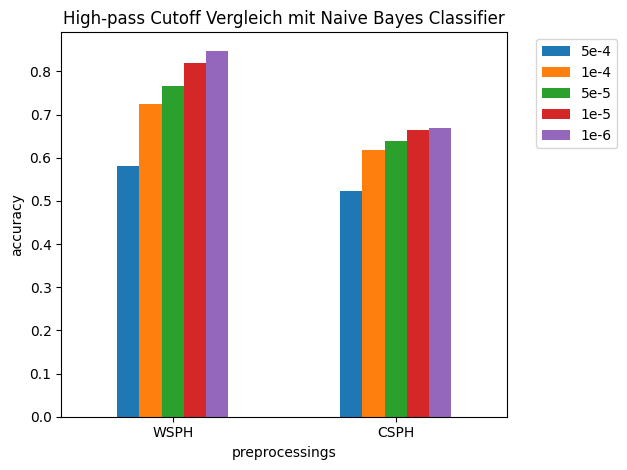

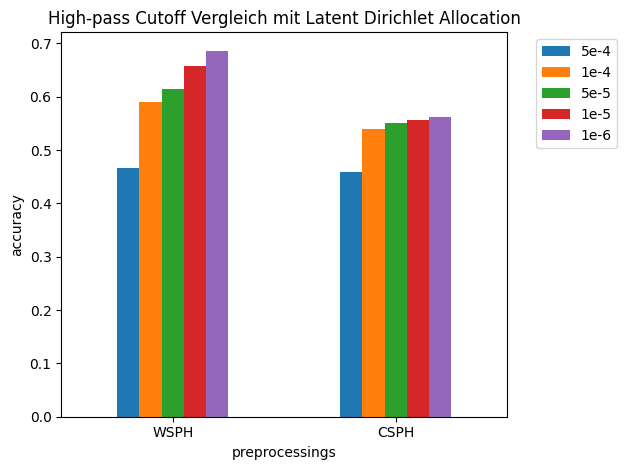

In [14]:
for method in ["bayes", "lda"]:
    score_df = pd.DataFrame()
    for preprocessing in ["CSPH","WSPH"]:
        method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})(?=.*{preprocessing})")]
        method_df = method_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
        method_df = method_df.rename(columns=lambda x: re.sub(r'^\D*(\d.*)', r'\1', x))
        score_df[preprocessing] = method_df.iloc[: , 2:].apply(lambda x: accuracy_score(method_df["author_short"], x))
    score_df = score_df.pivot_table(columns=score_df.index, sort=False).reindex(["WSPH", "CSPH"])
    score_df.plot.bar(rot=0,ylabel="accuracy", xlabel="preprocessings", title=f"High-pass Cutoff Vergleich mit {methods[method]}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{method}_highpass.png", dpi=300)


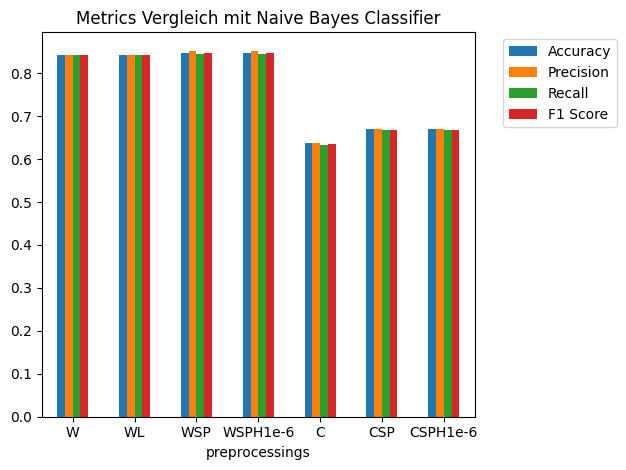

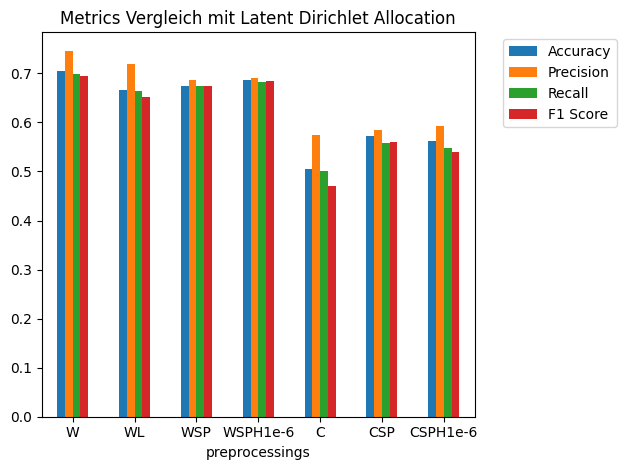

In [10]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![45]).)*)$")]
    method_df = method_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
    score_df = pd.DataFrame()
    for name, func in metrics:
        score_df[name] = method_df.iloc[:, 2:].apply(lambda x: func(method_df["author_short"], x))
    score_df.plot.bar(rot=0, xlabel="preprocessings", title=f"Metrics Vergleich mit {methods[method]}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{method}_metrics.png", dpi=300)



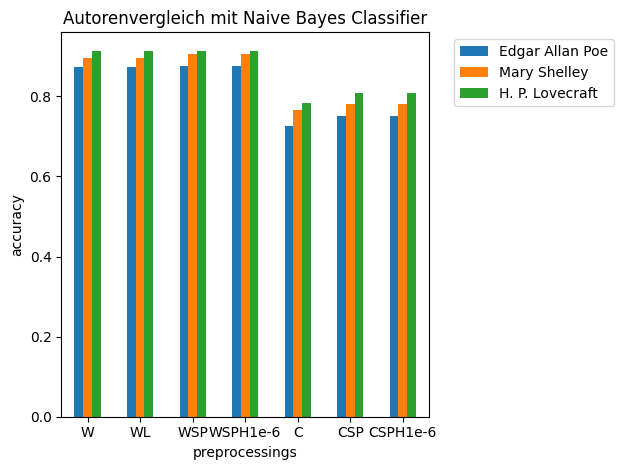

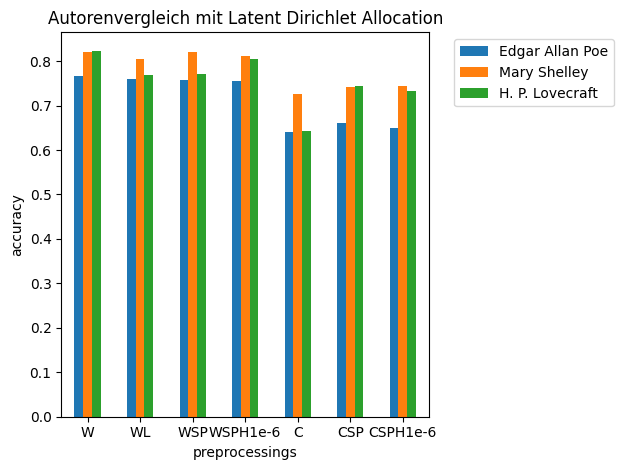

In [16]:
for method in ["bayes", "lda"]:
    name = "Accuracy"
    func = accuracy_score
    score_df = {}
    method_df = df.loc[:, df.columns.str.contains(
        f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![45]).)*)$")]
    for author in ["EAP", "MWS", "HPL"]:
        author_df = pd.DataFrame(
            {"author": method_df["author"]})
        author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
            lambda x: [1 if author == i else 0 for i in x])], axis=1)
        author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
        score_df[author] = author_df.iloc[:, 2:].apply(
            lambda x: func(author_df["author_short"], x))
    score_df = pd.DataFrame(score_df)
    score_df = score_df.rename(columns=lambda x: authors_short_dict[x])
    score_df.plot.bar(title=f"Autorenvergleich mit {methods[method]}", rot=0, ylabel=name.lower(), xlabel="preprocessings")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"authors_{method}.png", dpi=300)